# 1. Business Objectives

- Objective function		 	 	 		
- Any metric you wish to optimize in addition to accuracy 
- The intended user 
- Any business rules you think will be important 
- Performance requirements (time and/or complexity) 
- And more (for example: interpretability, diversity, novelty, etc) 		

In [ ]:
# objective function: State your business objective, and how this would translate to the metrics that you will ultimately be optimizing for.



# 2. Model Exploration & Evaluation 

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from item_based_cf import *
from metrics_helper import *

In [3]:
df = pd.read_csv('./ml-latest/ratings.csv')
df.drop("timestamp", inplace=True, axis=1)

The number of unique users is 283228
The number of unique items is 53889
The sparsity is 99.818%


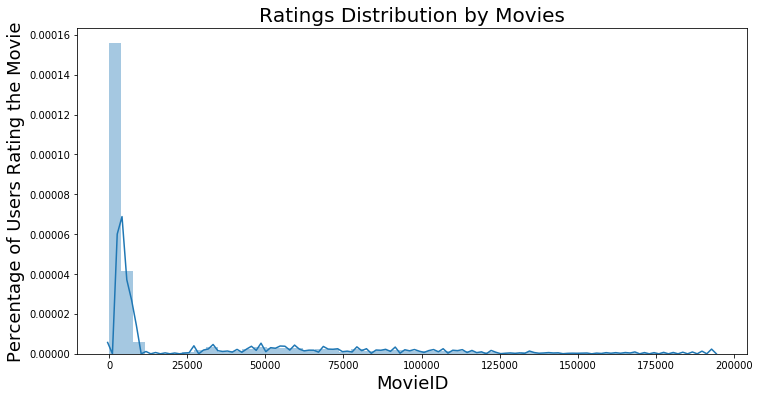

In [26]:
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = round(1.0-len(df)/float(n_users*n_items),5)
print(f'The number of unique users is {n_users}')
print(f'The number of unique items is {n_items}')
print(f'The sparsity is {sparsity*100}%')

fig, ax = plt.subplots(figsize=(12,6))
fig = sns.distplot(df['movieId'])
ax.set_ylabel('Percentage of Users Rating the Movie', size=18)
ax.set_xlabel('MovieID', size=18)
ax.set_title('Ratings Distribution by Movies', size=20)
plt.show()

In [ ]:
# cover movies of all popularity level: set some lower threshold for movies, like only include movies with greater than 5 or 100 ratings, but I wouldn't select only the most popular movies.
# If you include all levels of popularity it would be great to subset your accuracy results by popularity. Do you see a curve in accuracy from least to most popular?

# sample from sampled dataset


## 2.1 Memory-based Collaborative Filtering

### 2.1.1 Data preprocessing

In [4]:
##default param is 300 and 6800, which can satisfy hw requirement, and it takes about 6 hours to train and predict
df_sample = sample_df(df, min_item=2000, min_user=10000)

number of users: 423
number of items: 685
shape of sampled df: (215855, 3)


In [6]:
df_sample.head()

,userId,movieId,rating
128418,1272,1,3.5
128419,1272,7,2.0
128420,1272,11,4.0
128421,1272,16,2.5
128422,1272,21,3.0


In [19]:
train_set, test_set = train_test_split(df_sample, test_size=0.50)
train_set, valid_set = train_test_split(train_set, test_size=0.2)
rating_matrix_train = train_set.pivot(index='movieId', columns='userId', values='rating')
rating_matrix_test = test_set.pivot(index='movieId', columns='userId', values='rating')

### 2.1.2 Model Training 

In [40]:
model1 = ItemBasedCF(5, 'pearson')

In [42]:
start = time.time()
model1.fit(rating_matrix_train)
end = time.time()
print(f'training_time in seconds: {end-start}')

training_time in seconds: 249.86608266830444


### 2.1.3 Model Tuning with Cross validation

In [8]:
model1.train_set

array([[3.5, 5. , 5. , ..., 5. , 2. , 4.5],
       [nan, nan, 3.5, ..., 3. , nan, nan],
       [nan, 2.5, 4. , ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, 3.5],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, 4.5, nan, ..., nan, nan, nan]])

In [43]:
start = time.time()
pred_set = model1.predict(rating_matrix_test)
end = time.time()
print(f'training_time in seconds: {end-start}')

training_time in seconds: 5.763369083404541


In [20]:
rating_matrix_test

userId,1272,2025,2150,2294,2329,2551,2629,4027,4605,4796,...,276799,277685,278022,278420,280148,280585,280868,281631,281790,283000
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,2.5,...,4.5,NaN,2.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN
2,NaN,2.0,NaN,NaN,3.0,1.0,3.5,4.0,1.5,NaN,...,3.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.5,NaN,NaN,2.5,NaN,NaN,NaN
5,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.5,NaN,3.5,3.0,NaN,NaN,NaN,NaN,3.5
6,NaN,NaN,4.5,3.5,NaN,2.0,NaN,5.0,NaN,3.5,...,NaN,3.0,NaN,NaN,NaN,4.5,4.0,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122882,NaN,5.0,NaN,3.0,3.5,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,4.5
122886,2.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.5,NaN,NaN,3.5,NaN,NaN,4.5
122904,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
class ItemBasedCF():
    def __init__(self, k_neighbors = 10, similarity_metrics = 'pearson'):
        self.train_set = None
        self.similarity_matrix = None
        self.k_neighbors = k_neighbors
        self.similarity_metrics = similarity_metrics

    def fit(self, train_df, dummy_y):
        train_df = train_set.pivot(index='movieId', columns='userId', values='rating')
        
        self.train_set = train_df.values
        self.similarity_matrix = sim_matrix(self.train_set, self.similarity_metrics)

    def predict(self, test_df):
        test_df = test_df.pivot(index='movieId', columns='userId', values='rating')
        
        pred_df = np.zeros(test_df.shape)
        train_set_filled = np.nan_to_num(self.train_set)
        nbrs = NearestNeighbors(n_neighbors=self.k_neighbors+1, algorithm='ball_tree').fit(train_set_filled)
        distances, indices = nbrs.kneighbors(train_set_filled)
        
        # return average score of each movie with NAN ignored
        mean_item = np.nanmean(self.train_set, axis=1)
        for i in range(len(pred_df)):
            pred_df[i][:] = mean_item[i]
            neighbor_indice = indices[i][1:]
            for j in range(len(pred_df[i])):
                if np.isnan(self.train_set[i][j]):
                    pred_df[i][j] += np.nansum(self.similarity_matrix[i][neighbor_indice] * (
                                self.train_set[:, j][neighbor_indice] - mean_item[neighbor_indice])) / np.sum(
                        self.similarity_matrix[i][neighbor_indice])
                else:
                    pred_df[i][j] = np.nan
        return pred_df
    
    # requested methods for sk-learn estimator
    def get_params(self, deep = True):
        return {"k_neighbors": self.k_neighbors, "similarity_metrics": self.similarity_metrics}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [145]:
# Reform loss function for gridsearch
def My_MAE(pred_df, test_df):
    try:
        test_df = test_df.pivot(index='movieId', columns='userId', values='rating')
    except:
        pass
    try: 
        pred_df = pred_df.pivot(index='movieId', columns='userId', values='rating')
    except:
        pass
    return MAE(pred_df, test_df)
scoring = make_scorer(MAE, greater_is_better = False)

In [146]:
parameters = {'similarity_metrics':['pearson','cosine'], 'k_neighbors':np.arange(10,35,5)}
model_test = ItemBasedCF()
gs = GridSearchCV(model_test, parameters, scoring = scoring, cv=3)

In [147]:
gs.fit(df_sample, df_sample)

Scoring...
Score: 0.7978431541311273
Scoring...
Score: 0.8195688859964169
Scoring...
Score: 0.8179840985704184
Scoring...
Score: 0.7074448314858226
Scoring...
Score: 0.7291387195075585
Scoring...
Score: 0.7319413175852879
Scoring...
Score: 0.726941693069136
Scoring...
Score: 0.7547516930767583
Scoring...
Score: 0.7552161866750662
Scoring...
Score: 0.7039049126677552
Scoring...
Score: 0.7262980162223681
Scoring...
Score: 0.7294587806655276
Scoring...
Score: 0.7241876162222423
Scoring...
Score: 0.7544452894619395
Scoring...
Score: 0.7538648681119012
Scoring...
Score: 0.7016679049536826
Scoring...
Score: 0.725059501327104
Scoring...
Score: 0.7283887665266569
Scoring...
Score: 0.7275732053185932
Scoring...
Score: 0.757914096595795
Scoring...
Score: 0.7581272251950621
Scoring...
Score: 0.7006744331147879
Scoring...
Score: 0.7244823722458328
Scoring...
Score: 0.7277497953039721
Scoring...
Score: 0.7055868941340561
Scoring...
Score: 0.7347542122867237
Scoring...
Score: 0.7369684075425936
Scor

GridSearchCV(cv=3, error_score=nan,
             estimator=<__main__.ItemBasedCF object at 0x1a1580b310>,
             iid='deprecated', n_jobs=None,
             param_grid={'k_neighbors': array([10, 15, 20, 25, 30]),
                         'similarity_metrics': ['pearson', 'cosine']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(MAE, greater_is_better=False), verbose=0)

In [149]:
print(gs.best_params_)

{'k_neighbors': 30, 'similarity_metrics': 'cosine'}


In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = abs(cv_results['mean_test_score'])
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

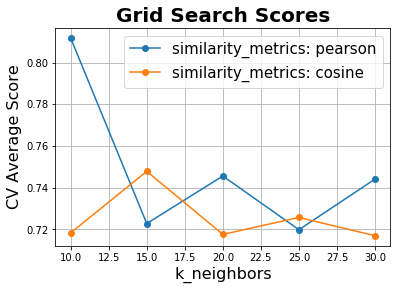

In [159]:
# Calling Method 
plot_grid_search(gs.cv_results_, parameters['k_neighbors'], parameters['similarity_metrics'], 'k_neighbors', 'similarity_metrics')


### 2.1.4 Model Evaluation

- ROC-based metrics (recall, precision, roc curve, auc)
- DCG
- coverage
- scalability

In [161]:
model = ItemBasedCF(30, 'cosine')

In [163]:
pred = model.predict(test_set)

ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
MAE(rating_matrix_test, pred_set)

0.6885897602816633

In [22]:
MSE(rating_matrix_test, pred_set)

0.7899858612161919

In [29]:
dcg(rating_matrix_test.values, pred_set)

22.91174836018709

In [160]:
def precision(predicted, actual):
    """
    Computes the precision of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        precision: int
    """
    def calc_precision(predicted, actual, k):
        prec = [value for value in predicted if value in actual[:k]]
        prec = np.round(float(len(prec)) / float(len(predicted)), 4)
        return prec

    precision = np.mean(list(map(calc_precision, predicted, actual)))
    return precision

### 2.1.5 Reflection

- Other design choices to consider?

## 2.2 Model-based  Collaborative Filtering

### 2.2.1 Data preprocessing

### 2.2.2 Model Training

### 2.2.3 Model Tuning with Cross validation

### 2.2.4 Model Evaluation

- ROC-based metrics (recall, precision, roc curve, auc)
- DCG
- coverage
- scalability

### 2.2.5 Reflection

- Other design choices to consider?

# 3. Final Recommendation

- Final recommendation to your manager
- Reasons and potential watch outs 